In [1]:
%pip install -q --no-warn-conflicts malariagen_data

In [2]:
%pip install google.oauth2.credentials

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement google.oauth2.credentials (from versions: none)
ERROR: No matching distribution found for google.oauth2.credentials


In [1]:
!pip install --upgrade google-auth

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: libtorrent 2.0.5-build-libtorrent-rasterbar-qrM5vM-libtorrent-rasterbar-2.0.5-bindings-python has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of libtorrent or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
import numpy as np
import dask
import dask.array as da
from dask.diagnostics.progress import ProgressBar
import malariagen_data
import pandas as pd
import collections

In [5]:
release_data = malariagen_data.Pf7()
variant_data = release_data.variant_calls()
variant_data

<xarray.Dataset> Size: 3TB
Dimensions:              (variants: 10145661, alleles: 7, samples: 20864,
                          ploidy: 2)
Coordinates:
    variant_position     (variants) int32 41MB dask.array<chunksize=(8388608,), meta=np.ndarray>
    variant_chrom        (variants) object 81MB dask.array<chunksize=(4194304,), meta=np.ndarray>
    sample_id            (samples) object 167kB dask.array<chunksize=(20864,), meta=np.ndarray>
Dimensions without coordinates: variants, alleles, samples, ploidy
Data variables:
    variant_allele       (variants, alleles) object 568MB dask.array<chunksize=(699051, 1), meta=np.ndarray>
    variant_filter_pass  (variants) bool 10MB dask.array<chunksize=(10145661,), meta=np.ndarray>
    variant_is_snp       (variants) bool 10MB dask.array<chunksize=(10145661,), meta=np.ndarray>
    variant_numalt       (variants) int32 41MB dask.array<chunksize=(8388608,), meta=np.ndarray>
    variant_CDS          (variants) bool 10MB dask.array<chunksize=(10145661,), meta=np.ndarray>
    call_genotype        (variants, samples, ploidy) int8 423GB dask.array<chunksize=(167773, 100, 2), meta=np.ndarray>
    call_AD              (variants, samples, alleles) int16 3TB dask.array<chunksize=(23968, 100, 7), meta=np.ndarray>

In [6]:
genf = release_data.genome_features()
genf[genf['ID'] == 'PF3D7_1343700']

,contig,source,type,start,end,score,strand,phase,ID,Parent,Name,alias
32356,Pf3D7_13_v3,chado,gene,1724600,1727877,NaN,-,NaN,PF3D7_1343700,NaN,Kelch13,NaN


In [7]:
# Take data from the variant_data xarray object, process it, and create a new dataframe named df_variants containing variant information
variants_dict = collections.OrderedDict()
variants_dict['Type'] = pd.Series(variant_data['variant_is_snp'][:]).map({True: 'SNP', False: 'non-SNP'})
variants_dict['Multiallelic'] = pd.Series(variant_data['variant_numalt'][:] == 1).map({True: 'Bi-allelic', False: 'Multi-allelic'})
variants_dict['Coding'] = pd.Series(variant_data['variant_CDS'][:]).map({True: 'Coding', False: 'Non-coding'})
variants_dict['is_pass'] = variant_data['variant_filter_pass'][:]
variants_dict['num_alleles'] = variant_data['variant_numalt'][:] + 1
variants_dict['Chrom'] = pd.Series(variant_data['variant_chrom'][:])
variants_dict['pos'] = pd.Series(variant_data['variant_position'][:])
df_variants = pd.DataFrame.from_dict(variants_dict)
df_variants.loc[df_variants['Type']=='non-SNP', 'Multiallelic'] = ''

print(df_variants.shape)

display(df_variants.head(3))

(10145661, 7)


,Type,Multiallelic,Coding,is_pass,num_alleles,Chrom,pos
0,non-SNP,,Non-coding,False,2,Pf3D7_01_v3,30
1,non-SNP,,Non-coding,False,4,Pf3D7_01_v3,37
2,non-SNP,,Non-coding,False,3,Pf3D7_01_v3,51


In [65]:
validated_snps = {
    "F446I": 1725662,
    "Y493H": 1725521, 
    "R539T": 1725382, 
    "I543T": 1725370,
    "P553L": 1725340, 
    "R561H": 1725316, 
    "P574L": 1725277, 
    "C580Y": 1725259, 
    "A675V": 1724974
    }
validated_snps.values()

dict_values([1725662, 1725521, 1725382, 1725370, 1725340, 1725316, 1725277, 1725259, 1724974])

In [66]:
# Conditions
# condition = (df_variants['Chrom'] == 'Pf3D7_13_v3') & (df_variants['pos'].isin(range(1724600,1727877)))
condition = (df_variants['Chrom'] == 'Pf3D7_13_v3') & (df_variants['pos'].isin(validated_snps.values()))

# Find rows where conditions are met
matching_rows = df_variants[condition]

print(condition)

0           False
1           False
2           False
3           False
4           False
            ...  
10145656    False
10145657    False
10145658    False
10145659    False
10145660    False
Length: 10145661, dtype: bool


In [67]:
validated_positions = {
    key: df_variants.index[(df_variants['pos'] == value) & (df_variants['Chrom'] == 'Pf3D7_13_v3')].tolist() 
    for key, value in validated_snps.items()
}
validated_positions

{'F446I': [8189179],
 'Y493H': [8189130],
 'R539T': [8189082],
 'I543T': [8189077],
 'P553L': [8189064],
 'R561H': [8189056],
 'P574L': [8189038],
 'C580Y': [8189029],
 'A675V': [8188919]}

In [68]:
validated_positions_vec = [item for sublist in validated_positions.values() for item in sublist]
validated_positions_vec

[8189179,
 8189130,
 8189082,
 8189077,
 8189064,
 8189056,
 8189038,
 8189029,
 8188919]

In [69]:
allele_dict = collections.OrderedDict()
allele_dict["al1"] = pd.Series(variant_data['variant_allele'][validated_positions_vec, 0])
allele_dict["al2"] = pd.Series(variant_data['variant_allele'][validated_positions_vec, 1])
allele_dict["al3"] = pd.Series(variant_data['variant_allele'][validated_positions_vec, 2])
allele_dict["al4"] = pd.Series(variant_data['variant_allele'][validated_positions_vec, 3])
allele_dict["al5"] = pd.Series(variant_data['variant_allele'][validated_positions_vec, 4])
allele_dict["al6"] = pd.Series(variant_data['variant_allele'][validated_positions_vec, 5])
allele_dict["al7"] = pd.Series(variant_data['variant_allele'][validated_positions_vec, 6])
all = pd.DataFrame.from_dict(allele_dict)
all

,al1,al2,al3,al4,al5,al6,al7
0,A,T,,,,,
1,A,G,,,,,
2,C,G,*,,,,
3,A,G,,,,,
4,G,A,,,,,
5,C,T,,,,,
6,G,A,,,,,
7,C,T,A,,,,
8,G,A,,,,,


In [70]:
ref = variant_data['call_AD'][validated_positions_vec, :, 0].values
alt = variant_data['call_AD'][validated_positions_vec, :, 1].values

In [88]:
ad = pd.DataFrame((alt/(ref+alt)).transpose())
ad.columns = validated_positions.keys()
ad['Sample'] = pd.Series(variant_data['sample_id'][:])

/tmp/ipykernel_49294/1684578462.py:1: RuntimeWarning: invalid value encountered in divide
  ad = pd.DataFrame((alt/(ref+alt)).transpose())


In [89]:
ad['k13'] = ad.drop('Sample', axis=1).max(axis=1, skipna=True)
ad

,F446I,Y493H,R539T,I543T,P553L,R561H,P574L,C580Y,A675V,Sample,k13
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FP0008-C,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FP0009-C,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FP0010-CW,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FP0011-CW,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FP0012-CW,0.0
...,...,...,...,...,...,...,...,...,...,...,...
20859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SPT43399,0.0
20860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SPT43400,0.0
20861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SPT43401,0.0
20862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPT43403,NaN


In [95]:
res = ad[ad["k13"] > 0]
res

,F446I,Y493H,R539T,I543T,P553L,R561H,P574L,C580Y,A675V,Sample,k13
929,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,0.0,PC4097-C,0.333333
1001,0.0,0.0,0.0,0.0,0.0,0.498747,0.0,0.000000,0.0,PD0068-C,0.498747
1012,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,PD0079-C,1.000000
1056,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,PD0126-C,1.000000
1083,0.0,0.0,0.0,NaN,NaN,1.000000,0.0,0.000000,0.0,PD0153-C,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
20236,NaN,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,SPT41904,1.000000
20250,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,SPT41933,0.142857
20259,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.148148,0.0,SPT41951,0.148148
20295,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.0,SPT42018,0.500000


In [93]:
# Check that this looks correct by visual comparison against Panoptes for ease
sample_values = ["PD0554-C", "PV0285-C"]
ad[ad['Sample'].isin(sample_values)]

,F446I,Y493H,R539T,I543T,P553L,R561H,P574L,C580Y,A675V,Sample,k13
1188,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.933333,0.0,PD0554-C,0.933333
6364,0.0,0.0,0.985714,0.0,0.0,0.0,0.0,0.000000,0.0,PV0285-C,0.985714


We then check this against panoptes:

- 86Y is the first mixed SNP from left to right, showing heterozygous for 30-C (pink shade), homozygous alt for 32-C and homozygous ref for the the other samples. 

- 184F is the second mixed SNP from left to right, showing heterozygous for 30-C, homozygous alt for 32-C and 34-C and homozygous ref for the the other sample. 

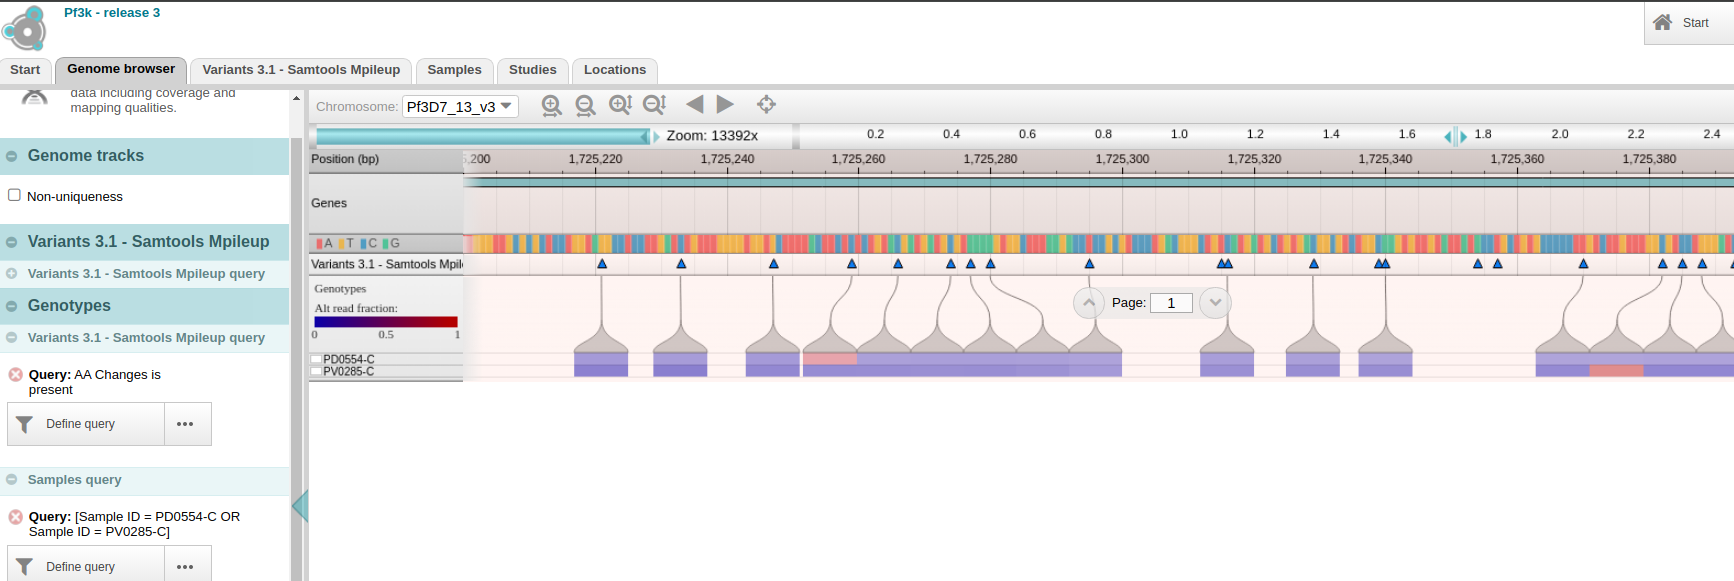

Link for checking: https://apps.malariagen.net/apps/pf3k/release_3/index.html?dataset=Pf3k_3_0_pilot&workspace=workspace_1&view=ddd4a814-f749-11ee-a8e8-0699e85f00d7&state=genomebrowser

In [94]:
# Save this file out
ad.to_csv('kelch.csv', index=False)